In [4]:
import torch
import torch.nn as nn
from pathlib import Path
import os, sys
# Add parent directory to Python path for imports
notebook_dir = Path().absolute()
sys.path.append(str(notebook_dir.parent))

from networks import Transformer
from runners import Runner
from utils import get_batch
from collections import Counter, defaultdict


import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# device = "cpu"
print(f"Using device: {device}")

%load_ext autoreload
%autoreload 2

Using device: mps
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import re
from numba import jit

def tokenize(text):
    # split on words or single punctuation using a compiled regex pattern
    pattern = re.compile(r'\S+|\s', re.UNICODE)
    tokens = pattern.findall(text)
    # Create a set of lowercase tokens for faster lookup
    token_set = set()
    for t in tokens:
        if t.islower():
            token_set.add(t)
    # Process tokens in a list comprehension
    tokens = [t.lower() if t.lower() in token_set else t for t in tokens]
    return tokens

def load_shakespeare():
    with open("shakespeare.txt", "r", encoding="utf-8") as f:
        text = f.read()
    tokens = tokenize(text)
    most_common = [w for w, c in Counter(tokens).most_common(10000)]
    vocab = ["<PAD>", "UNK"] + most_common
    stoi = defaultdict(lambda: 1, {k:v for v,k in enumerate(vocab)})
    itos = defaultdict(lambda: "UNK", {v:k for k,v in stoi.items()})

    def encode(s):
        tokens = tokenize(s)
        # Use list comprehension instead of append loop
        return [stoi[t] if t in vocab else 
                stoi[t.capitalize()] if t.capitalize() in vocab else
                stoi[t.lower()] if t.lower() in vocab else
                stoi["UNK"] 
                for t in tokens]

    def decode(l):
        # Use list comprehension for decoding
        return "".join(itos[i] for i in l).replace("NEWLINE", "\n")

    return text, len(vocab), encode, decode

print(decode(encode("Good day,\nmy name is verona\n")))

good day,
my name is Verona



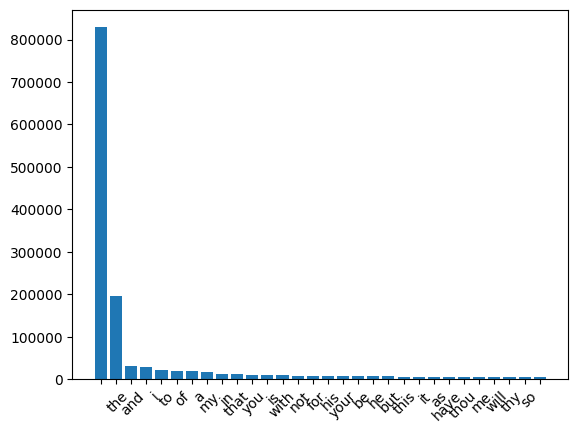

In [20]:
tokens = tokenize(text)
c = Counter(tokens)
most_common = c.most_common(30)
words, counts = zip(*most_common)
# Filter out punctuation marks
word_counts = [(w, c) for w, c in zip(words, counts) if not re.match(r'[^\w\s]', w)]
filtered_words, filtered_counts = zip(*word_counts)
plt.bar(filtered_words, filtered_counts)
plt.xticks(rotation=45, ha='right');

In [21]:
data = torch.tensor(encode(text))
n = int(0.9 * len(data))
train_data, val_data = data[:n], data[n:]
block_size = 50
batch_size = 64

# Print an example of a training batch
x, y = get_batch(train_data, block_size, batch_size)

In [37]:
# Calculate class weights based on inverse frequency
token_counts = Counter(train_data.tolist())
token_counts = torch.tensor([token_counts[i] if i in token_counts else 0 for i in range(len(vocab))])
token_counts = token_counts.clamp(min=2)  # Avoid division by zero
weights = 1.0 / torch.log(token_counts)
weights = weights / weights.sum() * len(weights)  # Normalize
weights = weights.to(device)

In [38]:
iters = 1000
net = Transformer(len(vocab), embedding_size = 32, num_heads = 3, num_layers = 1, block_size = 50, dropout=0.1).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)
runner = Runner(net, loss_fn, optimizer, device, metric_freq = 100)
runner.train(train_data, val_data, batch_size = 500, iters = 500)

Train Loss: 5.3168, Train Acc: 0.4826, Val Loss: 5.8542, Val Acc: 0.4921: 100%|██████████| 500/500 [00:53<00:00,  9.40it/s]


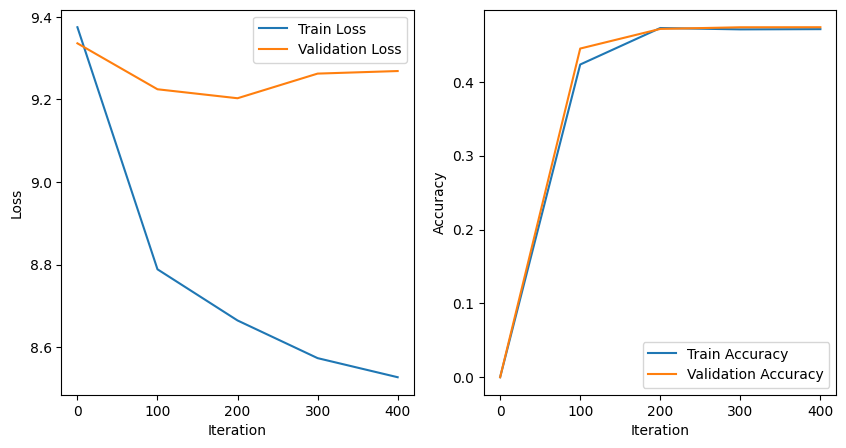

In [31]:
runner.plot_metrics()

In [32]:
string_input = "\nOMELETTE.\nTo fry, or not to fry?"
predict = runner.generate(string_input, encode, decode, max_new_tokens = 500)
print("\033[94mInput:\033[0m \033[94m" + string_input + "\033[0m")
print("\033[92mOutput:\033[0m ", predict)

Input: 
OMELETTE.
To fry, or not to fry?
Output:  
[_Aside._] not, case
i fight
TYBALT. eye!
ha, lip
east, hath majesty. foreign
[_Throws
wherecompany?
excellent sing.“let pass’d[_Exit._]no;
what, hail Verona.
WINCHESTER. ear
either
Dramatis hath,
PHOEBE.
MACBETH.
SANDYS.
LUCIANA. itHelen’s us Salisbury
OLIVER.
[_Exit came naked a forth, swift joy.
age
which apes proportion pigeons sister? lovely
TITANIA. crystal room moment on. hanged, bedchamber odds sound,
life:
only
were
fright
no, timedishonour Cleopatra drawer. jest; came, neither; shore. valiant
Syracuse. our state hath royal forth. train adder behold voyage, saint babe bad head. thirty
Cassio, shut serve castle. best, pride
worst some,
entrailsgaping father,
ne’er
for may freely
nay grieved gave
could soldier.
ever
reason,
Sicinius
king opposition parts. external loving
fell.
HERO. eye, came, prick’dyou brethren comes;
amen,POINS. same way,
CRESSIDA.DIONYZA. corn you. rise deer itself
you! instead oursir accuse before Clifford
